
Copyright (c) 2019 Computational-Medicine

# Convert DICOMs to NIFTI using dcm2niix

dcm2niix is a designed to convert neuroimaging data from the DICOM format to the NIfTI format.

This software should run on macOS, Linux and Windows typically without requiring any other software. However, if you use dcm2niix to create gz-compressed images it will be faster if you have pigz installed. You can get a version of both dcm2niix and [pigz](https://github.com/madler/pigz) compiled for your operating system by downloading [MRIcroGL](https://github.com/rordenlab/MRIcroGL12/releases). There is also an optional [batch processing version](https://github.com/rordenlab/dcm2niix/blob/master/BATCH.md) of dcm2niix.


### Install

There are a couple ways to install dcm2niix

 - [Github Releases](https://github.com/rordenlab/dcm2niix/releases) provides the latest compiled executables. This is an excellent option for MacOS and Windows users. However, the provided Linux executable requires a recent version of Linux, so the provided Unix executable is not suitable for all distributions.
 - [MRIcroGL](https://github.com/rordenlab/MRIcroGL12/releases) includes dcm2niix that can be run from the command line or from the graphical user interface (select the Import menu item). The Linux version of dcm2niix is compiled on a holy build box, so it should run on any Linux distribution.
 - If you have a MacOS computer with Homebrew you can run brew install dcm2niix.
 - If you have Conda, `conda install -c conda-forge dcm2niix` on Linux, MacOS or Windows (may be not the latest version)
 - On Debian Linux computers you can run sudo apt-get install dcm2niix.


In [112]:
%matplotlib inline

In [113]:
import os
import pathlib
import pandas as pd
import numpy as np
home = os.path.expanduser('~')  # To make path to local home directory

# We assume you have made a directory ~/prj/BMED360/data

### Download zipped DICOM data from a Google Drive

https://drive.google.com/file/d/1S-Og-5-T8N8wxfqR4hm2bFrP0pEsaliN/view?usp=sharing

In [114]:
# https://github.com/nsadawi/Download-Large-File-From-Google-Drive-Using-Python/blob/master/Download-Large-File-from-Google-Drive.ipynb

# taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [115]:
file_id = '1S-Og-5-T8N8wxfqR4hm2bFrP0pEsaliN'
subj_id = 'lg_prisma_20160218'
destination = '%s/prj/BMED360/data/%s.zip' % (home, subj_id)
#download_file_from_google_drive(file_id, destination)

### Unzip DICOM files to a target directory

https://stackoverflow.com/questions/3451111/unzipping-files-in-python

In [116]:
from zipfile import ZipFile

path_to_extract_folder = '%s/prj/BMED360/data' % (home)
#zf = ZipFile(destination, 'r')
#zf.extractall(path_to_extract_folder)
#zf.close()

In [117]:
#!tree path_to_extract_folder /f /a
cmd = 'tree %s /a' % (path_to_extract_folder)
print(os.popen(cmd).read())

Folder PATH listing for volume Local Disk
Volume serial number is 82A6-EE0C
C:\USERS\ARVID\PRJ\BMED360\DATA
\---lg_prisma_20160218
    +---dicom
    \---nifti



## dcm2niix

https://github.com/rordenlab/dcm2niix

git clone git@github.com:rordenlab/dcm2niix.git

https://www.nitrc.org/plugins/mwiki/index.php/dcm2nii:MainPage

conda install -c conda-forge dcm2niix

Download: https://github.com/rordenlab/dcm2niix <br>
Usage: https://www.nitrc.org/plugins/mwiki/index.php/dcm2nii:MainPage#General_Usage

In [118]:
DCMCONVERT = '%s/prj/BMED360/bin/dcm2niix_11-Apr-2019_win/dcm2niix.exe' % (home)
print(os.popen(DCMCONVERT).read())

Compression will be faster with pigz.exe in the same folder as the executable
Chris Rorden's dcm2niiX version v1.0.20190410  (JP2:OpenJPEG) (JP-LS:CharLS) MSC1900 (64-bit Windows)
usage: dcm2niix.exe [options] <in_folder>
 Options :
  -1..-9 : gz compression level (1=fastest..9=smallest, default 6)
  -a : adjacent DICOMs (images from same series always in same folder) for faster conversion (n/y, default n)
  -b : BIDS sidecar (y/n/o [o=only: no NIfTI], default y)
   -ba : anonymize BIDS (y/n, default y)
  -c : comment stored in NIfTI aux_file (provide up to 24 characters)
  -d : directory search depth. Convert DICOMs in sub-folders of in_folder? (0..9, default 5)
  -e : export as NRRD instead of NIfTI (y/n, default n)
  -f : filename (%a=antenna (coil) name, %b=basename, %c=comments, %d=description, %e=echo number, %f=folder name, %i=ID of patient, %j=seriesInstanceUID, %k=studyInstanceUID, %m=manufacturer, %n=name of patient, %p=protocol, %r=instance number, %s=series number, %t=time,

In [119]:
subjs = ['lg_prisma_20160218']
mydcm = '%s/%s/dicom' % (path_to_extract_folder, subj_id)
mynii = '%s/%s/nifti' % (path_to_extract_folder, subj_id)

In [120]:
def my_dcm2niix(mydcm, mynii, subj):
    for i in range(len(subj)):
        s = subj[i]
    
        # Convert to NIFTI (all sequences)
        source_dir = mydcm
        output_dir = mynii
        pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
    
        # cmd = [
        # '/usr/local/bin/dcm2niix',
        # '/home/arvid/anaconda3/bin/dcm2niix',
        # 'C:\\Users\\arvid\\Anaconda3\\Library\\bin\\dcm2niix',
        # 'C:\Users\arvid\Anaconda3\Library\bin\dcm2niix.exe'
        cmd = [
            DCMCONVERT,
            '-d', '9',
            '-b', 'y',
            '-m', 'n',
            '-s', 'n',
            '-t', 'n',
            '-x', 'n',
            '-z', 'y',
            '-i', 'y',
            '-f', subj[i]+'_%s_%p_%n_%t',
            '-o', output_dir,
            source_dir]
        #  '-f', '%p_%t_%s',    see help:  dcm2niix -h
        cmd_str = " ".join(cmd)
        print('cmd_str = \n%s\n' % cmd_str)
        #os.system(cmd_str)

In [121]:
my_dcm2niix(mydcm, mynii, subjs)

cmd_str = 
C:\Users\arvid/prj/BMED360/bin/dcm2niix_11-Apr-2019_win/dcm2niix.exe -d 9 -b y -m n -s n -t n -x n -z y -i y -f lg_prisma_20160218_%s_%p_%n_%t -o C:\Users\arvid/prj/BMED360/data/lg_prisma_20160218/nifti C:\Users\arvid/prj/BMED360/data/lg_prisma_20160218/dicom



In [122]:
#!tree path_to_extract_folder /f /a
cmd = 'tree %s/%s/nifti /f /a' % (path_to_extract_folder, subj_id)
print(os.popen(cmd).read())

Folder PATH listing for volume Local Disk
Volume serial number is 82A6-EE0C
C:\USERS\ARVID\PRJ\BMED360\DATA\LG_PRISMA_20160218\NIFTI
    lg_prisma_20160218_10_ep2d_bold_moco_p2_3mm_RS_MoCo_fou_160218_Brain-Gut_lg_20160218140906.json
    lg_prisma_20160218_10_ep2d_bold_moco_p2_3mm_RS_MoCo_fou_160218_Brain-Gut_lg_20160218140906.nii.gz
    lg_prisma_20160218_2_t1_mprage_sag_1mm_fou_160218_Brain-Gut_lg_20160218140906.json
    lg_prisma_20160218_2_t1_mprage_sag_1mm_fou_160218_Brain-Gut_lg_20160218140906.nii.gz
    lg_prisma_20160218_3_ep2d_diff_qspace_p2_fou_160218_Brain-Gut_lg_20160218140906.bval
    lg_prisma_20160218_3_ep2d_diff_qspace_p2_fou_160218_Brain-Gut_lg_20160218140906.bvec
    lg_prisma_20160218_3_ep2d_diff_qspace_p2_fou_160218_Brain-Gut_lg_20160218140906.json
    lg_prisma_20160218_3_ep2d_diff_qspace_p2_fou_160218_Brain-Gut_lg_20160218140906.nii.gz
    lg_prisma_20160218_9_ep2d_bold_moco_p2_3mm_RS_fou_160218_Brain-Gut_lg_20160218140906.json
    lg_prisma_20160218_9_ep2d_bold_mo

### T1w

In [123]:
import shutil

subj = 'sub-01'

src_fn = '%s/%s/nifti/lg_prisma_20160218_2_t1_mprage_sag_1mm_fou_160218_Brain-Gut_lg_20160218140906' % ((path_to_extract_folder, subj_id))
dest_fn = '../data/mri/mybids/%s/anat/%s_T1w'  % (subj, subj)
exts = ['json', 'nii.gz']
for ext in exts:
    print('shutil.copy2(%s.%s, %s.%s' % (src_fn, ext, dest_fn, ext))
    s = '%s.%s' % (src_fn, ext)
    d = '%s.%s' % (dest_fn, ext)
    shutil.copy2(s, d)

shutil.copy2(C:\Users\arvid/prj/BMED360/data/lg_prisma_20160218/nifti/lg_prisma_20160218_2_t1_mprage_sag_1mm_fou_160218_Brain-Gut_lg_20160218140906.json, ../data/mri/mybids/sub-01/anat/sub-01_T1w.json
shutil.copy2(C:\Users\arvid/prj/BMED360/data/lg_prisma_20160218/nifti/lg_prisma_20160218_2_t1_mprage_sag_1mm_fou_160218_Brain-Gut_lg_20160218140906.nii.gz, ../data/mri/mybids/sub-01/anat/sub-01_T1w.nii.gz


### dwi

In [124]:
src_fn = '%s/%s/nifti/lg_prisma_20160218_3_ep2d_diff_qspace_p2_fou_160218_Brain-Gut_lg_20160218140906' % ((path_to_extract_folder, subj_id))
dest_fn = '../data/mri/mybids/%s/dwi/%s_dwi' % (subj, subj)
exts = ['bval', 'bvec', 'json', 'nii.gz']
for ext in exts:
    print('shutil.copy2(%s.%s, %s.%s' % (src_fn, ext, dest_fn, ext))
    s = '%s.%s' % (src_fn, ext)
    d = '%s.%s' % (dest_fn, ext)
    shutil.copy2(s, d)

shutil.copy2(C:\Users\arvid/prj/BMED360/data/lg_prisma_20160218/nifti/lg_prisma_20160218_3_ep2d_diff_qspace_p2_fou_160218_Brain-Gut_lg_20160218140906.bval, ../data/mri/mybids/sub-01/dwi/sub-01_dwi.bval
shutil.copy2(C:\Users\arvid/prj/BMED360/data/lg_prisma_20160218/nifti/lg_prisma_20160218_3_ep2d_diff_qspace_p2_fou_160218_Brain-Gut_lg_20160218140906.bvec, ../data/mri/mybids/sub-01/dwi/sub-01_dwi.bvec
shutil.copy2(C:\Users\arvid/prj/BMED360/data/lg_prisma_20160218/nifti/lg_prisma_20160218_3_ep2d_diff_qspace_p2_fou_160218_Brain-Gut_lg_20160218140906.json, ../data/mri/mybids/sub-01/dwi/sub-01_dwi.json
shutil.copy2(C:\Users\arvid/prj/BMED360/data/lg_prisma_20160218/nifti/lg_prisma_20160218_3_ep2d_diff_qspace_p2_fou_160218_Brain-Gut_lg_20160218140906.nii.gz, ../data/mri/mybids/sub-01/dwi/sub-01_dwi.nii.gz


### task-rest_bold

In [125]:
src_fn = '%s/%s/nifti/lg_prisma_20160218_10_ep2d_bold_moco_p2_3mm_RS_MoCo_fou_160218_Brain-Gut_lg_20160218140906' % ((path_to_extract_folder, subj_id))
dest_fn = '../data/mri/mybids/%s/func/%s_task-rest_bold' % (subj, subj)
exts = ['json', 'nii.gz']
for ext in exts:
    print('shutil.copy2(%s.%s, %s.%s' % (src_fn, ext, dest_fn, ext))
    s = '%s.%s' % (src_fn, ext)
    d = '%s.%s' % (dest_fn, ext)
    shutil.copy2(s, d)

shutil.copy2(C:\Users\arvid/prj/BMED360/data/lg_prisma_20160218/nifti/lg_prisma_20160218_10_ep2d_bold_moco_p2_3mm_RS_MoCo_fou_160218_Brain-Gut_lg_20160218140906.json, ../data/mri/mybids/sub-01/func/sub-01_task-rest_bold.json
shutil.copy2(C:\Users\arvid/prj/BMED360/data/lg_prisma_20160218/nifti/lg_prisma_20160218_10_ep2d_bold_moco_p2_3mm_RS_MoCo_fou_160218_Brain-Gut_lg_20160218140906.nii.gz, ../data/mri/mybids/sub-01/func/sub-01_task-rest_bold.nii.gz


### Check and edit som items in the  .json files

In [126]:
import json
from pprint import pprint

fn = '../data/mri/mybids/sub-01/anat/sub-01_T1w'+'.json'
with open(fn) as data_file:    
    data = json.load(data_file)
# data.keys()
# data.items()
pprint(data)

{'AcquisitionMatrixPE': 256,
 'AcquisitionNumber': 1,
 'AcquisitionTime': '14:10:57.452500',
 'BaseResolution': 256,
 'BodyPartExamined': 'BRAIN',
 'CoilString': 'HE1-4;NE1_2;SP1',
 'ConsistencyInfo': 'N4_VD13D_LATEST_20130810',
 'ConversionSoftware': 'dcm2niix',
 'ConversionSoftwareVersion': 'v1.0.20190410  (JP2:OpenJPEG) (JP-LS:CharLS) '
                              'MSC1900',
 'DeviceSerialNumber': '66035',
 'DwellTime': 9.8e-06,
 'EchoTime': 0.00228,
 'FlipAngle': 8,
 'ImageOrientationPatientDICOM': [-0.00393099,
                                  0.999992,
                                  7.66697e-09,
                                  0.0853443,
                                  0.000335498,
                                  -0.996351],
 'ImageType': ['ORIGINAL', 'PRIMARY', 'M', 'ND', 'NORM'],
 'ImagingFrequency': 123.256,
 'InPlanePhaseEncodingDirectionDICOM': 'ROW',
 'InstitutionAddress': 'Jonas_Lies_vei_65_Bergen_District_NO_5021',
 'InstitutionName': 'Haukeland_universitetssj

In [127]:
# Make some info 'NA'
data['InstitutionAddress'] = 'NA'
data['InstitutionName'] = 'NA'
data['InstitutionalDepartmentName'] = 'NA'
with open(fn, 'w') as outfile:
    json.dump(data, outfile, sort_keys=True, indent=4)
#pprint(data)

In [128]:
fn = '../data/mri/mybids/sub-01/dwi/sub-01_dwi'+'.json'
with open(fn) as data_file:    
    data = json.load(data_file)
# data.keys()
# data.items()
pprint(data)

{'AcquisitionMatrixPE': 100,
 'AcquisitionNumber': 1,
 'AcquisitionTime': '14:21:3.245000',
 'BandwidthPerPixelPhaseEncode': 35.714,
 'BaseResolution': 100,
 'BodyPartExamined': 'BRAIN',
 'ConsistencyInfo': 'N4_VD13D_LATEST_20130810',
 'ConversionSoftware': 'dcm2niix',
 'ConversionSoftwareVersion': 'v1.0.20190410  (JP2:OpenJPEG) (JP-LS:CharLS) '
                              'MSC1900',
 'DerivedVendorReportedEchoSpacing': 0.000560004,
 'DeviceSerialNumber': '66035',
 'DiffusionScheme': 'Bipolar',
 'DwellTime': 2.4e-06,
 'EchoTime': 0.079,
 'EchoTrainLength': 43,
 'EffectiveEchoSpacing': 0.000280002,
 'FlipAngle': 90,
 'ImageOrientationPatientDICOM': [0.996788,
                                  0.00126201,
                                  0.0800744,
                                  3.94129e-09,
                                  0.999876,
                                  -0.0157585],
 'ImageType': ['ORIGINAL',
               'PRIMARY',
               'DIFFUSION',
               'NONE'

In [129]:
# Make some info 'NA'
data['InstitutionAddress'] = 'NA'
data['InstitutionName'] = 'NA'
data['InstitutionalDepartmentName'] = 'NA'
with open(fn, 'w') as outfile:
    json.dump(data, outfile, sort_keys=True, indent=4)
#pprint(data)

In [130]:
fn = '../data/mri/mybids/sub-01/func/sub-01_task-rest_bold'+'.json'
with open(fn) as data_file:    
    data = json.load(data_file)
# data.keys()
# data.items()

**TaskName**

```python
1: [ERR] You have to define 'TaskName' for this file. (code: 50 - TASK_NAME_MUST_DEFINE)
		./sub-01/func/sub-01_task-rest_bold.nii.gz
			You have to define 'TaskName' for this file. It can be included one of the following locations: /task-rest_bold.json, /bold.json, /sub-01/sub-01_task-rest_bold.json, /sub-01/sub-01_bold.json, /sub-01/func/sub-01_task-rest_bold.json, /sub-01/func/sub-01_bold.json

        Summary:                  Available Tasks:        Available Modalities: 
        11 Files, 121.97MB                                /participants         
        1 - Subject                                       T1w                   
        1 - Session                                       dwi                   
                                                          bold                  

If you have any questions please post on https://neurostars.org/tags/bids
```
Let's begin with the defining `TaskName`. To do this, we will be editing the functional scan's json files. There are required fields that need to be present in each func json file. For this dataset, we notice upon opening the json's that they have defined repetition time and slice timing, but not task name. The task name needs to be the same name given as the task-<TaskName> in the filename. For example sub-101_ses-1_task-rest_bold.json ; the json will have 'TaskName': 'rest, 

In [131]:
# Have to add TaskName as rest in rs-fMRI json file
data.update({'TaskName': 'rest'})

pprint(data)

{'AcquisitionMatrixPE': 64,
 'AcquisitionNumber': 1,
 'AcquisitionTime': '14:37:26.780000',
 'BandwidthPerPixelPhaseEncode': 48.077,
 'BaseResolution': 64,
 'BodyPartExamined': 'BRAIN',
 'ConsistencyInfo': 'N4_VD13D_LATEST_20130810',
 'ConversionSoftware': 'dcm2niix',
 'ConversionSoftwareVersion': 'v1.0.20190410  (JP2:OpenJPEG) (JP-LS:CharLS) '
                              'MSC1900',
 'DerivedVendorReportedEchoSpacing': 0.000649999,
 'DeviceSerialNumber': '66035',
 'DwellTime': 4.4e-06,
 'EchoTime': 0.03,
 'EchoTrainLength': 31,
 'EffectiveEchoSpacing': 0.000324999,
 'FlipAngle': 90,
 'ImageComments': 'Reference_volume_for_motion_correction.',
 'ImageOrientationPatientDICOM': [0.996788,
                                  0.00126201,
                                  0.0800744,
                                  3.94129e-09,
                                  0.999876,
                                  -0.0157585],
 'ImageType': ['ORIGINAL', 'PRIMARY', 'M', 'ND', 'MOCO', 'MOSAIC'],
 'Imag

In [132]:
# Make some info 'NA'
data['InstitutionAddress'] = 'NA'
data['InstitutionName'] = 'NA'
data['InstitutionalDepartmentName'] = 'NA'
with open(fn, 'w') as outfile:
    json.dump(data, outfile, sort_keys=True, indent=4)
#pprint(data)

## BIDS

http://reproducibility.stanford.edu/bids-tutorial-series-part-1a/

BIDS validator: http://bids-standard.github.io/bids-validator

In [133]:
# BIDSHOME = '/mnt/c/Users/arvid/prj/BrainGut/my_bids'
BIDSHOME = '../data/mri/mybids'

In [134]:
cmd = 'ls -al %s' % (BIDSHOME)
process = os.popen(cmd)
o=process.read()
print(o)
process.close()

total 11
drwxr-xr-x 1 arvid 197609   0 Apr 19 16:33 .
drwxr-xr-x 1 arvid 197609   0 Apr 19 12:55 ..
-rw-r--r-- 1 arvid 197609 303 Apr 19 16:29 dataset_description.json
-rw-r--r-- 1 arvid 197609 481 Apr 19 16:33 participants.json
-rw-r--r-- 1 arvid 197609  47 Apr 19 17:50 participants.tsv
drwxr-xr-x 1 arvid 197609   0 Apr 19 12:49 sub-01



In [135]:
# Linux: cmd = 'tree %s' % (BIDSHOME)
cmd = 'tree %s /f /a' % (BIDSHOME)
process = os.popen(cmd)
o=process.read()
print(o)
process.close()

Folder PATH listing for volume Local Disk
Volume serial number is 82A6-EE0C
C:\USERS\ARVID\GITHUB\BMED360\DATA\MRI\MYBIDS
|   dataset_description.json
|   participants.json
|   participants.tsv
|   
\---sub-01
    +---anat
    |       sub-01_T1w.json
    |       sub-01_T1w.nii.gz
    |       
    +---dwi
    |       sub-01_dwi.bval
    |       sub-01_dwi.bvec
    |       sub-01_dwi.json
    |       sub-01_dwi.nii.gz
    |       
    \---func
            sub-01_task-rest_bold.json
            sub-01_task-rest_bold.nii.gz
            



### Check for BIDS compatibility

Command line version:
Install [Node.js](https://nodejs.org) (at least version 8.0)<br>
From a terminal run `npm install -g bids-validator`<br>
Run `bids-validator` to start validating datasets.

In [136]:
cmd = 'bids-validator %s --verbose' % BIDSHOME
process = os.popen(cmd)
o=process.read()
print(o)
process.close()

This dataset appears to be BIDS compatible.
        Summary:                  Available Tasks:        Available Modalities: 
        11 Files, 121.97MB        rest                    /participants         
        1 - Subject                                       T1w                   
        1 - Session                                       dwi                   
                                                          bold                  

If you have any questions please post on https://neurostars.org/tags/bids




**SliceTiming**

RECOMMENDED. The time at which each slice was acquired within each volume (frame) of the acquisition. Slice timing is not slice order -- rather, it is a list of times (in JSON format) containing the time (in seconds) of each slice acquisition in relation to the beginning of volume acquisition. The list goes through the slices along the slice axis in the slice encoding dimension (see below). Note that to ensure the proper interpretation of the `SliceTiming` field, it is important to check if the OPTIONAL `SliceEncodingDirection` exists. In particular, if `SliceEncodingDirection` is negative, the entries in `SliceTiming` are defined in reverse order with respect to the slice axis (i.e., the final entry in the `SliceTiming` list is the time of acquisition of slice 0). This parameter is REQUIRED for sparse sequences that do not have the DelayTime field set. In addition without this parameter slice time correction will not be possible.

Please note that some DICOM parameters have been traditionally expressed in milliseconds. Those need to be converted to seconds.

See also: https://github.com/rordenlab/dcm2niix/issues/163   and https://github.com/rordenlab/dcm2niix/tree/master/GE

One other suggestion - you may want to try [Xiangrui Li's dicm2nii](https://www.mathworks.com/matlabcentral/fileexchange/42997-dicom-to-nifti-converter--nifti-tool-and-viewer). I think he devoted more time than me in attempting to decode GE datasets. You may find that it provides a richer set of BIDS data than dcm2niix.

In [137]:
st = data['SliceTiming']
print(st)
arr = np.array(st)
print(list(arr/1000))

[1.11, 0, 1.165, 0.055, 1.22, 0.11, 1.275, 0.165, 1.3325, 0.2225, 1.3875, 0.2775, 1.4425, 0.3325, 1.4975, 0.3875, 1.5525, 0.4425, 1.61, 0.5, 1.665, 0.555, 1.72, 0.61, 1.775, 0.665, 1.83, 0.72, 1.8875, 0.7775, 1.9425, 0.8325, 1.9975, 0.8875, 2.0525, 0.9425, 2.1075, 0.9975, 2.165, 1.055]
[0.00111, 0.0, 0.001165, 5.5e-05, 0.00122, 0.00011, 0.0012749999999999999, 0.000165, 0.0013325, 0.00022250000000000001, 0.0013875, 0.0002775, 0.0014425, 0.0003325, 0.0014975000000000001, 0.0003875, 0.0015525, 0.0004425, 0.00161, 0.0005, 0.001665, 0.000555, 0.00172, 0.00061, 0.0017749999999999999, 0.000665, 0.00183, 0.0007199999999999999, 0.0018874999999999999, 0.0007775, 0.0019425, 0.0008325, 0.0019975, 0.0008874999999999999, 0.0020525, 0.0009425, 0.0021075, 0.0009975000000000001, 0.002165, 0.001055]


In [138]:
df = pd.read_csv('%s/participants.tsv' % (BIDSHOME), delimiter='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 4 columns):
participant_id    1 non-null object
gender            1 non-null object
age               1 non-null int64
group             1 non-null object
dtypes: int64(1), object(3)
memory usage: 112.0+ bytes


In [139]:
df.head()

,participant_id,gender,age,group
0,sub-01,M,29,HC


### Inspect images

In [140]:
import nibabel as nib
from nilearn import image
from nilearn import plotting
import matplotlib.pyplot as plt

In [141]:
# freeview -v ./sub-01/anat/sub-01_T1w.nii.gz ./sub-01/func/sub-01_task-rest_bold.nii.gz

In [142]:
anat_fn = BIDSHOME+'/sub-01/anat/sub-01_T1w.nii.gz'
func_fn = BIDSHOME+'/sub-01/func/sub-01_task-rest_bold.nii.gz'
dwi_fn = BIDSHOME+'/sub-01/dwi/sub-01_dwi.nii.gz'

C:\Users\arvid\Anaconda3\envs\bmed360\lib\site-packages\nilearn\image\resampling.py:510: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


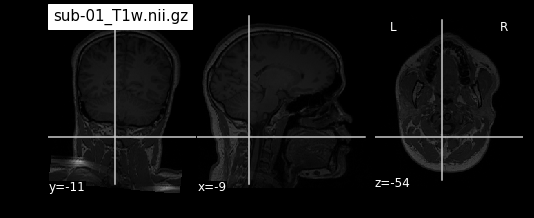

In [143]:
# inspect the resulting NIFTI file using plotting from nilearn
plotting.plot_anat(anat_fn, title="sub-01_T1w.nii.gz")

In [144]:
print(image.load_img(anat_fn).shape)

(192, 256, 256)


In [145]:
# using nibabel
img = nib.load(anat_fn)
data = img.get_data()
print(data.shape)

(192, 256, 256)


In [146]:
# check the dimensions of each voxel
print(img.header.get_zooms()[:3])

(1.0, 1.0, 1.0)


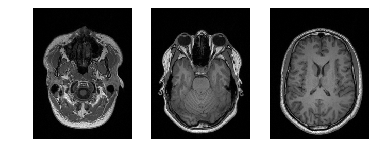

In [147]:
# show here the middle axial slices of 3D T1 image +/- offset slices
offset = 40
axial_middle = data.shape[2] // 2
plt.figure('Showing the dataset')
plt.subplot(1, 3, 1).set_axis_off()
plt.imshow(data[:, :, axial_middle - offset].T, cmap='gray', origin='lower')
plt.subplot(1, 3, 2).set_axis_off()
plt.imshow(data[:, :, axial_middle].T, cmap='gray', origin='lower')
plt.subplot(1, 3, 3).set_axis_off()
plt.imshow(data[:, :, axial_middle + offset].T, cmap='gray', origin='lower')
plt.show()

In [148]:
# print the full nifti header
print(img.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 54
dim             : [  3 192 256 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.  1.  1.  1.  1.8 0.  0.  0. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'TE=2.3;Time=141057.453;phase=1'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : -8.395315e-05
quatern_c       : 0.042711377
quatern_d       : 0.0019637048
qoffset_x       : -105.44209
qoffset_y       : -86.7565

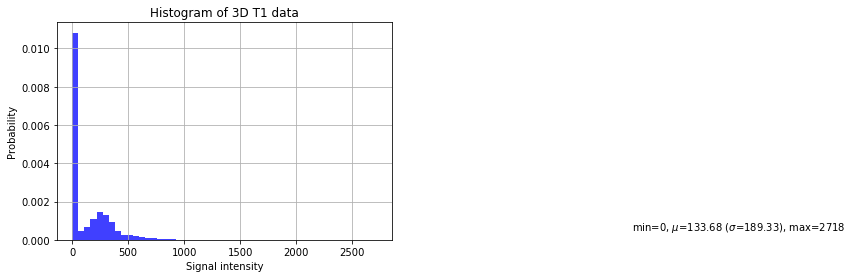

In [149]:
# the histogram of the 3D T1 data

x = data.flatten()
m, bins, patches = plt.hist(x, 50, density=True, facecolor='b', alpha=0.75)

mn = np.min(x)
mx = np.max(x)
mu = np.mean(x)
s = np.std(x)
txt = 'min=%d, $\mu$=%0.2f ($\sigma$=%0.2f), max=%d' % (mn, mu, s, mx)
plt.xlabel('Signal intensity')
plt.ylabel('Probability')
plt.title('Histogram of 3D T1 data')
plt.text(5000, .0005, txt)
plt.grid(True)
plt.show()